# GPT from scratch

このファイルではGPTモデルの実装を目標とする。このファイルの立ち位置は同リポジトリに含まれている<br>
・pytorch_command.ipynb<br>
・attention_from_scratch.ipynb<br>
の次に読むことを想定されている。pytorchの下位APIは上２つの.ipynbで散々練習したので、上位APIを解禁して最新モデルを組むことを目指す<br>
<br>
お詫び: このファイルでは最終的に訓練フェースにおいてGPTの制作は叶わなかったので制作をしたい人は途中まで読んだのちに<br>
何で製作者が失敗したのかをまとめたlearning_notes.ipynbとImproved_GPT.ipynbを読んでほしい。<br>
Improved_GPT.ipynbではこのファイルで制作したデータセットを用いるので、データのダウンロードまではこのファイルで行えば良い。

pytorchに明るい人はこのipynbファイルから読んでも良い、pytorchに明るくない人は上２つのipynbファイルを公式ドキュメントとにらめっこして読むことをおすすめする。<br>
内容がわかりにくいと感じた人はGithub上もしくはXで作者に質問/書き換え要請を投げることができる。<br>

##### 本題
実装においては[GPT from scratch](https://jaketae.github.io/study/gpt/)やKarpathyの[minGPT](https://github.com/karpathy/minGPT), [nanoGPT](https://github.com/karpathy/nanoGPT)を参考にする。<br>
実装に関してはこのipynbを見なくとも紹介した2つのサイトを見れば良い。<br>

実装に入る前に簡単なGPTの実装方針についての概要について解説する。今回実装するのは初代GPTである。<br>
初代GPTは以下のような構造をしている<br>
- GPTはTransformerのDecoderのみを用いたモデルである。
- Embedding_dimは768, MultiheadAttentionのHead数は12, TransformerDecoderブロック数は12である。
- FFN層の活性化関数はGELUである。

訓練時の注意事項も記載しておく
- OptimizerはAdam, 学習率の最大値は2.5e-4, 2000iteratonで最大値に達し、<br>その後はCOSINEスケジューラーによってスケジューリングを行う。attention_from_scratch.ipynbで紹介したwarm_upの改善版のようなものである。<br>

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
import warnings
warnings.simplefilter('ignore')
print("CUDA環境が壊れていないことを祈りながら確認->", torch.cuda.is_available())

CUDA環境が壊れていないことを祈りながら確認-> True


まずは学習につかうTransformerDecoderLayerを定義する。デフォルトにtorch.nn.TransformerDecoderLayerがあるが、<br>
GPTにつかうDecoderLayerは"Attention is all you need"で紹介されているDecoder Layerとは少し異なっている。<br>
そのため、カスタムレイヤーを定義する必要がある。

参考のために比較画像を用意した。

### GPT
<img src = "https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-27_at_12.41.44_PM.png">

### Transformer
<img src = "https://user-images.githubusercontent.com/57289763/160270884-e1901241-a1e6-4890-a5e8-165e87f0c4da.png">

ではGPTのレイヤーをGPTDecoderLayerとして定義しよう。

In [2]:
class GPTDecoderLayer(nn.Module):
    def __init__(self, embedding_dim, ffn_dim, num_heads, drop_out_rate = 0., layer_eps=1e-05, batch_first = False):
        super().__init__()
        self.maskedmultiheadattention = nn.MultiheadAttention(embedding_dim, num_heads,batch_first=batch_first)
        self.dropout_selfattn = nn.Dropout(p = drop_out_rate)
        self.layernorm_selfattn = nn.LayerNorm(embedding_dim, eps = layer_eps)

        self.ffn = nn.Sequential(nn.Linear(embedding_dim, ffn_dim), nn.GELU(), nn.Linear(ffn_dim, embedding_dim))#GELUに変更
        self.layernorm_ffn = nn.LayerNorm(embedding_dim, eps = layer_eps)
        self.dropout_ffn = nn.Dropout(p = drop_out_rate)

    def forward(self, x, pad_mask_self = None, mask_self=None):
        dx, _ = self.maskedmultiheadattention(x,x,x,key_padding_mask = pad_mask_self, attn_mask = mask_self)

        dx = self.dropout_selfattn(dx)

        x = self.layernorm_selfattn(x+dx)

        dx = self.dropout_ffn(self.ffn(x))

        x = self.layernorm_ffn(x + dx)
        return x

製作したGPTDecoderLayerにEmbeddingとPositional EncodingをつければGPTモデルの定義が終わる。<br>
マスクの制作もGPTクラス内部に含める形で実装を行なう。<br>
だがここで注意しなければならなければならないことがある。<br>
TransformerモデルではPositional Encodingはsinとcosを用いて実装したが、<br>
GPTではこのPositional Encodingも学習可能パラメーターとして実装を行なう。<br>
GPTでのこれにあたる層はnn.Embedding(max_sequence_len, embedding_dim)として埋め込み層を定義する。この実装方法はKarpathyの[minGPT](https://github.com/karpathy/minGPT), [nanoGPT](https://github.com/karpathy/nanoGPT)を参考にしたものである。<br>
他にもnn.Parameter()で実装するものもあるようである。[GPT from scratch](https://jaketae.github.io/study/gpt/)<br>
OpenAIのWhisperなどのモデルではnn.Parameterで実装されていたので、もしかしたらそっちの方が良いかもしれない。

forward, generate, generate_sentenceについて補足を行う。<br>
forwardは入力を$(x_{0},x_{1},...,x_{N})$,出力を$(x_{1},x_{2},...,x_{N+1})$を予測するように作られている。そのため、入力データには未来のデータを使わないようにマスクを行う必要がある。<br>
ラベル用データ$y$が入力に入らないときは予測結果の最後、つまり$x_{N+1}$のトークン予測を出力として返すようにしている。<br>
二つ目に、generateメソッドでは今までのtokenを元に学習モデルを用いて次の文字を出力している。generate_sentenceメソッドではgenerateメソッドを繰り返してトークンを取り出している。<br>

In [3]:
class GPT(nn.Module):
    def __init__(self, vocab_size, embedding_dim, ffn_dim, num_heads, drop_out_rate = 0.,\
                  layer_eps=1e-05, batch_first = False, T = 10000, N = 1):
        super().__init__()
        #Tはmax_lenを表している
        self.embedding = nn.Embedding(vocab_size, embedding_dim,)
        self.positional_embedding = nn.Embedding(T, embedding_dim)
        self.decoder = nn.ModuleList([GPTDecoderLayer(embedding_dim, ffn_dim, num_heads, drop_out_rate,\
                                                               layer_eps, batch_first) for _ in range(N)])
        self.linear = nn.Linear(embedding_dim, vocab_size, bias = False)
        self.vocab_size = vocab_size
    def forward(self, x, y = None,pad_mask_self = None, mask_self=None):
        """
        yはxを1つだけずらしたデータである
        x = data[a:b]なら、y = data[a+1:b+1]となる。
        """
        x = self.embedding(x)
        pos = torch.arange(0,x.size(1),dtype=torch.long).unsqueeze(0).to(x.device)
        pos = self.positional_embedding(pos)
        x = x + pos
        for layer in self.decoder:
            x = layer(x, pad_mask_self = pad_mask_self, mask_self = mask_self)
        x = self.linear(x)
        if y != None:
            loss = F.cross_entropy(x.view(-1, x.size(-1)), y.view(-1), ignore_index=-1) 
            #ignore_index=-1はyをonehotベクトル化しないでcross_entropyを使うために使用
            pred = x.argmax(dim = -1).detach().cpu()
            return torch.clamp(loss, min = 1e-32, max = 10e9), pred
        loss = None
        pred = x[:,[-1],:].argmax(dim = -1)
        return loss, pred
    def create_mask(self, x: torch.tensor, x_pad: int, device: str):
        """
        (batch_size, sequence_length, embedding_dim)の入力を想定
        """
        """
        Trueが無視される値であることに注意すること
        """
        seq_len = x.size(1)
        #srcのマスク制作
        padding_mask = (x == x_pad)
        mask = torch.triu(torch.ones(size = (seq_len, seq_len))==1).transpose(0,1) #下三角行列を作る
        mask = mask.float().masked_fill(mask == 0, float("-inf")).masked_fill(mask==1.,float(0.0)).to(device)
        return padding_mask, mask

    @torch.no_grad()
    def generate(self,bos: str, sentence_size, tokenizer, device):
        self.eval()
        bos_tokenized = tokenizer.encode_ordinary(bos)
        bos_tokenized = bos_tokenized[-sentence_size:]
        bos_tokenized = torch.LongTensor([bos_tokenized])
        _, add_sentence = self(bos_tokenized.to(device))
        self.train()
        return add_sentence
    @torch.no_grad()
    def generate_sentence(self, bos: str, sentence_size, generate_tokens, tokenizer, device):
        return_sentence = bos
        for i in range(generate_tokens):
            add_sentence = self.generate(return_sentence, sentence_size, tokenizer,device)
            return_sentence += tokenizer.decode_batch(add_sentence.tolist())[0]
        return return_sentence

上手く動くか試しに検証してみよう。
入力は(batch_size, tokens) = (1, 6)のLongTensorで、create_maskでmaskを製作し、上手く動作することを確かめる。

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
x = torch.LongTensor([[2,10,20,100,512,3],[2,10,20,100,512,3],[2,10,20,100,512,3]]).to(device)
x = x.reshape(3,6)
embedding_size = 768
num_heads = 12
#KarpathyのminGPTを参考に、パラメーターを設定した。
gpt = GPT(50257, embedding_size, embedding_size*4, num_heads, 0.1, batch_first=True, T = 1024, N = 12).to(device)

In [8]:
padding_mask, mask = gpt.create_mask(x[0:2], 0, device)
loss, pred = gpt(x[0:2],x[1:3],padding_mask,mask)
print("Loss: \n",loss)
print("Pred: \n", pred)

Loss: 
 tensor(10.6196, device='cuda:0', grad_fn=<NllLossBackward0>)
Pred: 
 tensor([[18577, 26818,  1185, 41473,  5617,  1185],
        [ 1185, 26818,  1185, 17752, 42762,  3401]])


モデルの構造は以下の通りである。

In [9]:
print(gpt)

GPT(
  (embedding): Embedding(50257, 768)
  (positional_embedding): Embedding(1024, 768)
  (decoder): ModuleList(
    (0-11): 12 x GPTDecoderLayer(
      (maskedmultiheadattention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (dropout_selfattn): Dropout(p=0.1, inplace=False)
      (layernorm_selfattn): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=768, out_features=3072, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=3072, out_features=768, bias=True)
      )
      (layernorm_ffn): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout_ffn): Dropout(p=0.1, inplace=False)
    )
  )
  (linear): Linear(in_features=768, out_features=50257, bias=False)
)


気になるパラメーター数は以下のとおりである。

In [10]:
count_params = 0
for params in gpt.parameters():
    count_params += params.contiguous().view(-1).size(0)
print("The number of parameters is ", count_params)

The number of parameters is  163035648


GPT1のパラメーター数は1億程度であると言われているが、実際に組んだモデルでも1億程度になっていることが確かめられた。<br>
途方もない数字のように思えるが、全てのパラメーターがfloat32(4バイト)であることを考えて<br>簡単な計算を行なうと,
家にある普通のGPUでもモデルのパラメーターを乗せることができるとわかる。<br>

In [11]:
#念の為メモリを開放しておく
import gc
del gpt
del x
del padding_mask, mask
gc.collect()
torch.cuda.empty_cache()

以上でモデルの定義は終わりである。ここからはデータセットの定義に移る。<br>
GPTモデルでは分かち書きに工夫がなされている。これはByte-Pair Encodingと言われている。<br>
実装はやや複雑なので別ファイルで解説を行なうかもしれない。ここではtiktokenライブラリのGPT2Tokenizerを利用しようと思う。<br>
tiktokenはOpenAIから提供されているライブラリであり、huggingfaceから提供されているGPT2Tokenizerよりも<br>
早いことが知られている

In [9]:
#本当は実装したかったけどヤムナシ
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
tokenizer.encode_ordinary("This is a sample.")

[1212, 318, 257, 6291, 13]

データセットの定義を行なう。データはopenwebtextを用いることにする。

In [10]:
from datasets import load_dataset
num_proc_load_dataset = 8 #並列処理をどの程度行なうか
dataset = load_dataset("openwebtext", num_proc=num_proc_load_dataset)

ダウンロードしたらpickleで保存しておきましょう。

In [11]:
import pickle
with open("dataset.bin","wb") as p:
    pickle.dump(dataset,p)

In [12]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 8013769
    })
})

In [13]:
import pickle
with open("dataset.bin", "rb") as p:
    dataset = pickle.load(p)

In [14]:
dataset 

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 8013769
    })
})

これ以降はデータの処理のためにHugging FaceのDatasetDictに提供されている<br>
前処理メソッドを使って前処理を行っていきます。各メソッドの解説は[HuggingFace datasets process](https://huggingface.co/docs/datasets/process#map)にあります。

In [17]:
#dataset分割
split_dataset = dataset["train"].train_test_split(test_size=0.0005, seed=2357, shuffle=True)
split_dataset['val'] = split_dataset.pop('test') # rename the test split to val

In [18]:
split_dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 8009762
    })
    val: Dataset({
        features: ['text'],
        num_rows: 4007
    })
})

データセットをtrainとvalに分割したため、tokenizeを行います。<br>
mapメソッドは第一引数に辞書型を返す処理関数を与えます。<br>

In [20]:
def process(example):
        ids = tokenizer.encode_ordinary(example['text']) 
        ids.append(tokenizer.eot_token) #文末に<endoftext>tokenを追加
        #
        out = {'ids': ids, 'len': len(ids)}
        return out


tokenized = split_dataset.map(
        process,
        remove_columns=['text'],
        desc="tokenizing the splits",
        num_proc=num_proc_load_dataset,
    )

tokenizing the splits (num_proc=8): 100%|██████████| 4007/4007 [00:01<00:00, 2138.37 examples/s]


In [31]:
tokenized

DatasetDict({
    train: Dataset({
        features: ['ids', 'len'],
        num_rows: 8009762
    })
    val: Dataset({
        features: ['ids', 'len'],
        num_rows: 4007
    })
})

tokenizeを行ったら、同じようにpickleで保存しておく。ここまでで製作したdataset.binとtokenized_dataset.binはgithub内部にもおいておく。

In [21]:
import pickle
with open("tokenized_dataset.bin","wb") as p:
    pickle.dump(tokenized,p)

In [23]:
import pickle
with open("tokenized_dataset.bin", "rb") as p:
    tokenized = pickle.load(p)

tokenizeが終了したデータは一つのbinファイルにまとめる。このとき、train dataだけで800万データがあるため、<br>
メモリ上に全データが乗らない場合がある。こんなときはnumpy.memmapを使ってファイルに書き出しを行なう。<br>
numpy.memmap(filename, dtype, mode, shape)を指定すると、指定したファイルの置き場所にファイルが生成される。<br>
製作したnumpy.memmapファイルはnumpy.ndarrayと同じように値が書き込めるため、800万データを少しずつ書き込めばよい。<br>
更に詳しい説明は公式ドキュメントの[numpy.memmap](https://numpy.org/doc/stable/reference/generated/numpy.memmap.html)を参考にして欲しい。<br>

In [52]:
from tqdm import tqdm
for split, dset in tokenized.items():
    #split: train or val, dset: train_dataset or val_dataset
    filename = split+".bin"
    length = np.sum(dset["len"], dtype=np.uint64) #データの長さ
    write_data = np.memmap(filename, dtype = np.uint16, mode = "w+", shape = (length,)) #Vocabが50257サイズなのでuint16で事足りる
    iteration = 1024
    index = 0
    for iter_index in tqdm(range(iteration)):
        add_data = dset.shard(num_shards=iteration, index = iter_index, contiguous=True).with_format('numpy')
        #dataset.shardはnum_shardsに指定した数だけデータを分割する
        add_data = np.concatenate(add_data['ids'])
        add_length = len(add_data)
        write_data[index:index+add_length] = add_data
        index += add_length
    write_data.flush()

100%|██████████| 1024/1024 [00:00<00:00, 1293.09it/s]


製作したbinファイルはbinと名付けたフォルダに入れた。この先はそういったフォルダ構成を想定して作業をおこなう。

製作したbinファイルの読み込みもnumpy.memmap関数を用いて行なう。このときmode="r"としておくことに注意して欲しい、でないと上の作業をやり直す羽目になる。

In [4]:
train_data = np.memmap("bin/train.bin", dtype = np.uint16, mode = "r")
val_data = np.memmap("bin/val.bin", dtype = np.uint16, mode = "r")

データが読み込めたらデータローダーの制作に移る。しかし今回はDataLoaderを使ってデータを
取り出すのではなく、<br>関数を用いることとなる。<br>

In [5]:
sentence_size = 1024
batch_size = 6
device = "cuda" if torch.cuda.is_available() else "cpu"
def get_batch(split: str, batch_size = 256,device = "cpu")->torch.Tensor:
    data = train_data if split == 'train' else val_data
    index = torch.randint(len(data) - sentence_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+sentence_size]).astype(np.int64)) for i in index])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+sentence_size]).astype(np.int64)) for i in index])
    if device == "cuda":
        return x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    return x.to(device), y.to(device)

get_batch関数は(dataのサイズ-sentence_size)までのindexをbatch_sizeだけ生成し、batch_size分だけ、<br>
index:index+sentence_sizeのデータを入力データ、index+1:index+sentence_size+1のデータをラベルとしている。<br>
モデルのforwardは入力を$(x_{0},x_{1},...,x_{N})$,出力を$(x_{1},x_{2},...,x_{N+1})$を予測するように作られていることに対応している。

さてここで、残念なお知らせだが、このリポジトリ製作者のGPUはメモリが8GB程度しかないため、これ以上に学習に工夫を行なう必要がでてきた。<br>
手元のパソコンでも実行するためにはまずモデルの縮小を行なう必要があった。OpenAIのオリジナルのGPT1とことなり、<br>
今から学習するモデルには以下の変更点がある。<br>
- num_headsが12から6に
- encoderの繰り返し回数が6回に


また、float32のまま学習するとGPUのメモリが足りないため、torch.cuda.amp.GradScaler, torch.amp.autocastを活用することで、<br>
省メモリにし、学習を可能にした。詳しくはlearning_notes.ipynbに記した。<br>

In [6]:
import tiktoken
device = "cuda" if torch.cuda.is_available() else "cpu"
embedding_size = 768
num_heads = 6
tokenizer = tiktoken.get_encoding("gpt2")
#KarpathyのminGPTを参考に、パラメーターを設定した。
depth = 6
gpt = GPT(50257, embedding_size, embedding_size*4, num_heads, 0, batch_first=True, T = sentence_size, N = depth).to(device) 
#事前学習のときはDropout無し、ファインチューニングのときはありが好ましい
warmup_iters = 2000

optimizer = torch.optim.Adam(gpt.parameters(), lr = 0.0001)

学習の際に用いるCOS schedulerの定義を行なう。<br>
cos schedulerの定義式はwarm_upとmax_iterを用いて以下のとおりに表される。<br>
$$
\text{learning rate} = \text{max\_learning\_rate} \times \left\{
\begin{array}{ll}
\dfrac{\text{epoch}}{\text{warm up}} & \text{epoch} \lt \text{warm up} \\
\cos{(\dfrac{\text{epoch}}{\text{max\_iter}}\pi)} & \text{epoch} \ge \text{warm up}
\end{array}
\right.

$$

しかし、このschedulerはepochの最後の方になるほどパラメーターの調整度合いが非常に低くなり、学習の意味がなくなってしまう。<br>
このため、学習率の最小値を決めておき、今回は以下の更新式で実装を行なう。
$$
\text{learning rate} = \text{max\_learning\_rate} \times \left\{
\begin{array}{ll}
\dfrac{\text{epoch}}{\text{warm up}} & \text{epoch} \lt \text{warm up} \\
\min(\cos{(\dfrac{\text{epoch}}{\text{max\_iter}}\pi)}, \text{min\_lr}) & \text{epoch} \ge \text{warm up}
\end{array}
\right.
$$

In [7]:
lr_max = 2.5e-4
min_lr = 2.5e-5
max_iters = 10000
def get_lr(cur_iter):
    #cur_iter現在のiteration
    if cur_iter < warmup_iters:
        return lr_max * cur_iter / warmup_iters
    return max(lr_max * (np.cos(cur_iter / max_iters * np.pi) + 1), min_lr)

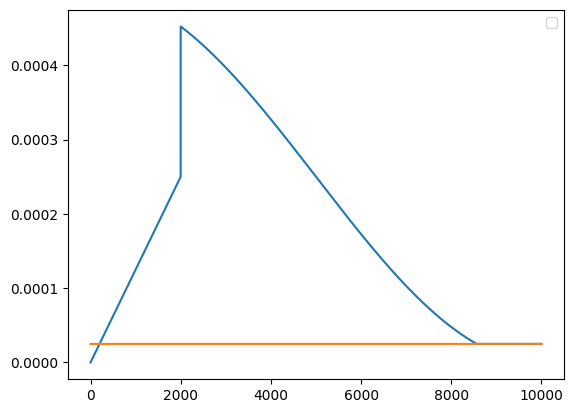

In [10]:
import matplotlib.pyplot as plt
iteration = np.arange(max_iters+1)
lr = np.array([get_lr(i) for i in iteration])
plt.plot(iteration, lr)
plt.plot(iteration, [min_lr]*len(iteration))
plt.legend(["learning rate"],["min_lr"])
plt.show()

今回はbatchの繰り返し回数を96回、最大epochを10000、学習状況を逐一保存することで途中からの開始が可能になるようにして学習をおこなった。<br>

In [ ]:
import gc
from tqdm import tqdm
batch_iteration = 96
scaler = torch.cuda.amp.GradScaler(enabled=True)
best_loss = 1e9
begin = 0
for cur_iter in tqdm(range(begin,max_iters)):
    optimizer.lr = get_lr(cur_iter+1)
    for batch_iter in range(batch_iteration):
        optimizer.zero_grad()
        with torch.amp.autocast(device_type=device, dtype=torch.float16):
            x,y = get_batch("train",batch_size=batch_size,device=device)
            padding_mask, mask = gpt.create_mask(x, 0, device)
            loss, pred = gpt(x,y,padding_mask,mask)
        scaler.scale(loss).backward() 
        scaler.step(optimizer) 
        scaler.update()
        if best_loss > loss.detach().item():
            best_loss = loss.detach().item()
            torch.save(gpt.state_dict(), "gpt.pth")
            print("params updated.")
            with open("learning_detail.txt","w") as f:
                f.write("学習状況\n")
                f.write(f"iter: {cur_iter}\n")
                f.write(f"hyper params: \n")
                f.write(f"vocab_size: 50257, embedding size: {embedding_size}, ffn: {embedding_size*4}, num_heads: {num_heads}, Depth: {depth}, sentnce_size: {sentence_size}\n")
                f.write(f"lr: {optimizer.lr},best_loss: {best_loss}\n")
                f.close()
        del x, y
        del padding_mask, mask
        del loss
        del pred
        gc.collect()
        torch.cuda.empty_cache()
    with open("learning_detail_latest.txt","w") as f:
        f.write("学習状況\n")
        f.write(f"iter: {cur_iter}\n")
        f.write(f"hyper params: \n")
        f.write(f"vocab_size: 50257, embedding size: {embedding_size}, ffn: {embedding_size*4}, num_heads: {num_heads}, Depth: {depth}, sentnce_size: {sentence_size}\n")
        f.write(f"lr: {optimizer.lr},best_loss: {best_loss}\n")
        f.close()
    torch.save(gpt.state_dict(), "gpt_latest.pth")

長いので一旦283/10000で学習を打ち切った。この状態での文章抽出を見てみよう。

In [12]:
gpt.generate_sentence("This is", sentence_size, 100, tokenizer, device)

'This is,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,'

これは明らかに失敗している。この状態ではまだ不十分なGPTになってしまうと考えられる。<br>
学習経過を観察した結果、100エポックを超えたあたりから損失があまり小さくならない勾配消失が起きていることが考えられた。<br>
これを改善したファイルがImproved_GPT.ipynbである。改善されたGPTを制作するために次はそちらを読むことをおすすめする。<br>
また、今回学習が失敗したと考えられる要因をlearning_notes.ipynbにまとめておいたため、そちらも読むと良い。

参考にしたサイトなど<br>
[https://blogs.nvidia.co.jp/2020/05/26/tensorfloat-32-precision-format/](https://blogs.nvidia.co.jp/2020/05/26/tensorfloat-32-precision-format/)<br>
[https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587](https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587)<br>
[https://qiita.com/Sosuke115/items/40265e6aaf2e414e2fea](https://qiita.com/Sosuke115/items/40265e6aaf2e414e2fea)<br>